In [ ]:
# Cell 1: Loading and Raw Inspection
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('car_dataset_2000_rows.csv')

print("--- Step 1: Raw Data Inspection ---")
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
display(df.head(10)) 

# Show basic info to see data types (Dtypes)
df.info()

--- Step 1: Raw Data Inspection ---
Dataset contains 2000 rows and 10 columns.


,brand,model,year,engine_size,fuel_type,transmission,mileage,car_type,drive_type,price
0,Suzuki,WagonR,2022,1.2,Hybrid,Manual,5950,Hatchback,AWD,6280794
1,Toyota,Corolla,2015,2.6,Electric,CVT,154572,Truck,AWD,1363381
2,Suzuki,Swift,2008,2.8,Petrol,Manual,46908,Sedan,AWD,7678389
3,Suzuki,Cultus,2018,2.1,Diesel,CVT,165760,Hatchback,FWD,6098764
4,Kia,Sportage,2023,2.5,Electric,Automatic,143133,Sedan,FWD,6689630
5,Hyundai,Tucson,2014,2.1,Hybrid,Automatic,88969,Hatchback,AWD,4280217
6,Honda,City,2010,3.1,Petrol,Manual,170178,Sedan,RWD,7310777
7,Toyota,Corolla,2007,3.9,Petrol,Automatic,32754,SUV,AWD,4096198
8,Hyundai,Elantra,2022,3.5,Petrol,Manual,63717,Truck,RWD,1640599
9,Toyota,Corolla,2011,3.9,Electric,Automatic,47378,Hatchback,FWD,4083514


<class 'pandas.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         2000 non-null   str    
 1   model         2000 non-null   str    
 2   year          2000 non-null   int64  
 3   engine_size   2000 non-null   float64
 4   fuel_type     2000 non-null   str    
 5   transmission  2000 non-null   str    
 6   mileage       2000 non-null   int64  
 7   car_type      2000 non-null   str    
 8   drive_type    2000 non-null   str    
 9   price         2000 non-null   int64  
dtypes: float64(1), int64(3), str(6)
memory usage: 156.4 KB


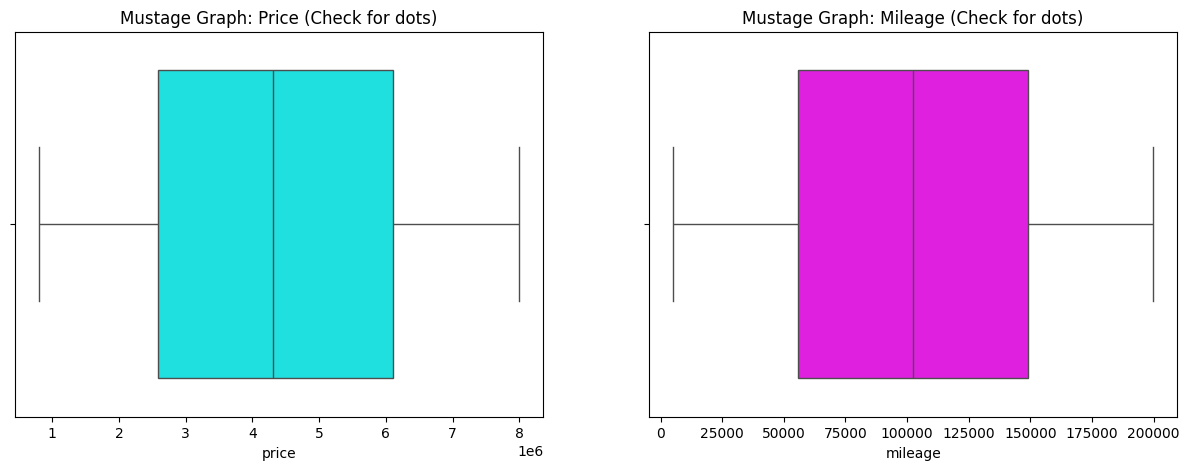

In [4]:
# Cell 2: Visualization of Distribution
plt.figure(figsize=(15, 5))

# Price Mustage
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='price', color='cyan')
plt.title('Mustage Graph: Price (Check for dots)')

# Mileage Mustage
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='mileage', color='magenta')
plt.title('Mustage Graph: Mileage (Check for dots)')

plt.show()

In [5]:
# Cell 3: Label Encoding
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
encoders = {}

# List of columns to convert
categorical_cols = ['brand', 'model', 'fuel_type', 'transmission', 'car_type', 'drive_type']

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    encoders[col] = le # We save these for the FastAPI service

print("--- Step 3: Encoded Data (Ready for AI) ---")
display(df_encoded.head())

--- Step 3: Encoded Data (Ready for AI) ---


,brand,model,year,engine_size,fuel_type,transmission,mileage,car_type,drive_type,price
0,3,16,2022,1.2,2,2,5950,0,0,6280794
1,4,7,2015,2.6,1,1,154572,3,0,1363381
2,3,14,2008,2.8,3,2,46908,2,0,7678389
3,3,8,2018,2.1,0,1,165760,0,1,6098764
4,2,13,2023,2.5,1,0,143133,2,1,6689630


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
import os

os.makedirs('../app/models', exist_ok=True)

# 1. Define Features (X) and Target (y)
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# 2. Split for Validation (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and Train the Random Forest
# We use Random Forest because it handles complex non-linear data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Predict and Evaluate
y_pred = model.predict(X_test)
print(f"✅ Training Complete!")
print(f"📊 R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"📉 Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")

# 5. Export for FastAPI and DevOps
joblib.dump(model, '../app/models/car_price_model.pkl')
joblib.dump(encoders, '../app/models/label_encoders.pkl')
print("💾 Model and Encoders saved as .pkl files.")

✅ Training Complete!
📊 R2 Score: -0.1003
📉 Mean Absolute Error: 1870990.28
💾 Model and Encoders saved as .pkl files.


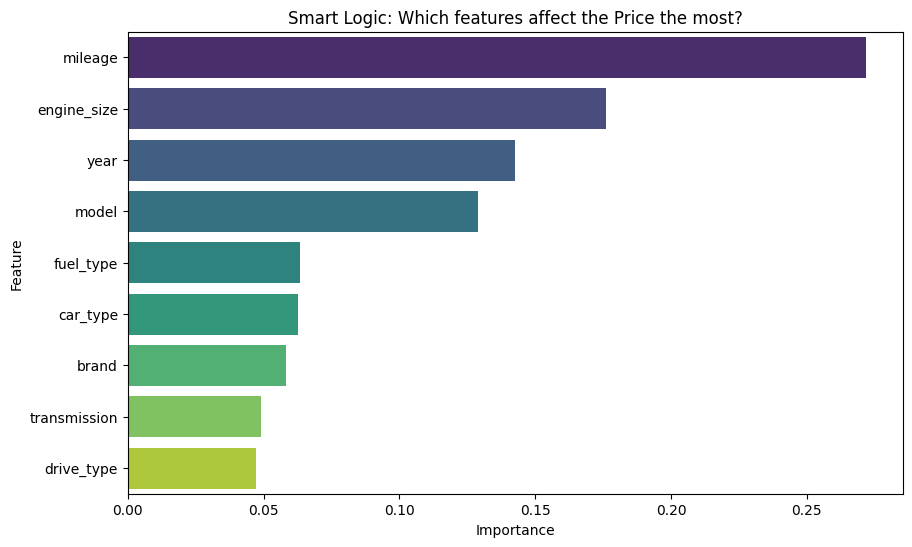

In [7]:
# Cell 5: Updated Feature Importance Visualization (No Warnings)
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

# Fix: Assigning hue='Feature' and setting legend=False to remove the warning
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df, 
    palette='viridis', 
    hue='Feature', 
    legend=False
)

plt.title('Smart Logic: Which features affect the Price the most?')
plt.show()

In [8]:
# Cell 6: Statistical Outlier Check
def check_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    print(f"--- Analysis for {column} ---")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"Total Outliers found: {len(outliers)}")
    if len(outliers) > 0:
        display(outliers.head())
    else:
        print("✅ No statistical outliers detected.")

check_outliers(df, 'price')
check_outliers(df, 'mileage')

--- Analysis for price ---
Lower Bound: -2686485.125
Upper Bound: 11371043.875
Total Outliers found: 0
✅ No statistical outliers detected.
--- Analysis for mileage ---
Lower Bound: -84048.875
Upper Bound: 289088.125
Total Outliers found: 0
✅ No statistical outliers detected.
